In [191]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import pickle

In [192]:
df = pd.read_csv('data/full_data.csv')

In [193]:
df

,date,lon_rounded_up,lat_rounded_up,o2,chl,no3,po4,si,salinity,temp,elevation
0,0,-95,-10,1.325735,-0.429394,0.283508,1.832926,0.448428,0.071110,-1.029641,-3849.2820
1,0,-95,-5,1.170324,0.034210,2.357263,2.142240,0.205595,-0.119146,-0.720057,-3892.6504
2,0,-95,0,-1.596509,0.387851,3.522180,2.959272,2.495748,-0.276508,-1.503058,-3487.2504
3,0,-95,5,-1.505413,0.183462,1.739879,2.076753,1.962417,-0.553741,-0.504464,-3276.1233
4,0,-95,10,-2.073315,0.012927,1.560748,1.806558,1.520656,-0.525955,-0.369803,-3636.0646
...,...,...,...,...,...,...,...,...,...,...,...
123601,762,0,-10,0.033041,-0.493187,-0.355084,-0.187822,-0.662790,0.351170,0.221984,-4937.6521
123602,762,0,-5,-0.548615,-0.349968,-0.159290,-0.118827,-0.495822,0.140582,0.771239,-4567.3715
123603,762,0,0,-0.373003,0.073440,0.113240,0.004906,-0.446959,-0.195972,0.673542,-4771.7100
123604,762,0,5,-0.277895,0.769255,0.209416,-0.043516,-0.549325,-0.238408,0.810580,-4243.9490


In [187]:
# Lag features
X = pd.DataFrame({
    'y_lag_2': df.shift(2), 
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': df.shift(-2),
    'y_step_2': df.shift(-1),
    'y_step_1': df,
})

ValueError: If using all scalar values, you must pass an index

In [189]:
X_train = pd.read_csv('data/X_train.csv')

In [190]:
X_valid = pd.read_csv('data/X_valid.csv')

In [51]:
X_test = pd.read_csv('data/X_test.csv')

In [52]:
y_train = pd.read_csv('data/Y_train.csv')

In [53]:
y_valid = pd.read_csv('data/Y_valid.csv')

In [54]:
y_test = pd.read_csv('data/Y_test.csv')

In [56]:
for df in [X_train, X_valid, X_test, y_train, y_valid, y_test]:
  df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [65]:
y_train.head()

,chl_lead_1,no3_lead_1,po4_lead_1,si_lead_1,salinity_lead_1,temp_lead_1,o2_lead_1,chl_lead_2,no3_lead_2,po4_lead_2,...,salinity_lead_29,temp_lead_29,o2_lead_29,chl_lead_30,no3_lead_30,po4_lead_30,si_lead_30,salinity_lead_30,temp_lead_30,o2_lead_30
0,-0.430037,0.279589,1.828939,0.439474,0.072170,-1.023362,1.320493,-0.430034,0.280439,1.825981,...,0.083279,-0.578967,0.982932,-0.402917,0.288722,1.716196,0.178475,0.082767,-0.575581,0.957246
1,0.024087,2.312757,2.128812,0.186297,-0.120111,-0.701991,1.171471,0.013961,2.265852,2.117300,...,-0.106680,-0.138282,0.744647,-0.142607,1.379151,1.919800,-0.045116,-0.106882,-0.132861,0.705863
2,0.383814,3.438312,2.933043,2.421313,-0.271519,-1.371162,-1.485713,0.376780,3.331120,2.898092,...,-0.315068,-0.560990,-0.827283,0.139506,2.065787,2.607572,2.331755,-0.315599,-0.543955,-0.856865
3,0.190233,1.779440,2.092174,1.990323,-0.548952,-0.487111,-1.580695,0.213279,1.848597,2.116703,...,-0.584142,-0.162526,-1.297279,0.038488,1.693948,2.037521,1.743925,-0.576579,-0.160394,-1.207453
4,0.002627,1.522824,1.792975,1.490038,-0.517718,-0.417696,-2.006727,-0.011855,1.481399,1.780491,...,-0.438855,-0.334576,-1.676833,-0.017104,1.671679,1.994646,1.332375,-0.438227,-0.315368,-1.607061


In [70]:
# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
predictions = model.predict(X_test) 

In [71]:

# model evaluation 
print( 
  'mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print( 
  'mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 


mean_squared_error :  0.19234482119193985
mean_absolute_error :  0.09862473258955878


In [19]:
df_X_train.tail()

,date,lon_rounded_up,lat_rounded_up,o2,chl,no3,po4,si,salinity,temp,...,salinity_lag_59,temp_lag_59,o2_lag_59,chl_lag_60,no3_lag_60,po4_lag_60,si_lag_60,salinity_lag_60,temp_lag_60,o2_lag_60
74029,456,0,-10,0.181694,-0.628871,-0.417839,-0.215535,-0.656872,0.367592,-0.013205,...,0.442617,0.058757,0.318796,-0.617426,-0.409726,-0.191601,-0.679693,0.442008,0.049059,0.319808
74030,456,0,-5,-0.413565,-0.469578,-0.344057,-0.295953,-0.474746,0.040567,0.632227,...,0.180388,0.580804,-0.271590,-0.545695,-0.374676,-0.228740,-0.542654,0.173369,0.585004,-0.271778
74031,456,0,0,-0.322352,-0.254412,-0.301801,-0.310577,-0.538758,-0.064017,0.900238,...,-0.073313,0.752320,-0.156366,-0.148585,-0.204168,-0.220887,-0.479361,-0.069811,0.701518,-0.156169
74032,456,0,5,-0.286759,-0.155938,-0.266013,-0.427961,-0.586722,-0.269975,1.286102,...,-0.209853,0.843739,-0.281220,0.478649,0.040628,-0.209548,-0.523424,-0.215700,0.830918,-0.287812
74033,456,0,10,-0.507095,1.436858,0.165012,0.015985,-0.367611,-0.085731,0.801712,...,-0.100454,-0.478071,-0.873882,2.844341,1.150728,0.677752,-0.166042,-0.102276,-0.553701,-1.174450


In [20]:
df_X_test = pd.read_csv('data/X_test.csv')
df_X_test = df_X_test.drop(columns='Unnamed: 0')

In [21]:
df_X_test.head()

,date,lon_rounded_up,lat_rounded_up,o2,chl,no3,po4,si,salinity,temp,...,salinity_lag_59,temp_lag_59,o2_lag_59,chl_lag_60,no3_lag_60,po4_lag_60,si_lag_60,salinity_lag_60,temp_lag_60,o2_lag_60
0,610,-95,-10,1.116656,-0.491450,0.047801,1.720371,0.603321,0.040990,-1.074772,...,0.026413,-0.761699,0.835826,-0.497189,-0.043738,1.610306,0.206711,0.025755,-0.753666,0.832154
1,610,-95,-5,0.451582,-0.231764,1.044927,2.515528,1.728150,-0.058102,-0.460978,...,-0.097442,-0.190279,0.144520,-0.347460,0.376830,2.190353,1.532341,-0.098985,-0.182387,0.145147
2,610,-95,0,-1.018040,0.386777,2.228068,2.983338,2.959818,-0.165277,-0.565714,...,-0.169231,-0.009983,-0.968355,0.160217,1.759002,2.657375,2.643030,-0.161780,0.003284,-0.973691
3,610,-95,5,-0.639054,-0.184053,0.449328,1.263440,0.852580,-0.642969,0.566984,...,-0.530431,0.671324,-0.896982,-0.112863,0.656469,1.516295,1.273888,-0.528780,0.703924,-0.837050
4,610,-95,10,-1.424603,-0.094073,0.578581,0.957442,0.373819,-0.804606,0.719884,...,-0.737647,0.768882,-1.275963,-0.011288,0.466039,0.970463,0.132182,-0.740493,0.801735,-1.280216


In [22]:
df_X_test.tail()

,date,lon_rounded_up,lat_rounded_up,o2,chl,no3,po4,si,salinity,temp,...,salinity_lag_59,temp_lag_59,o2_lag_59,chl_lag_60,no3_lag_60,po4_lag_60,si_lag_60,salinity_lag_60,temp_lag_60,o2_lag_60
24781,762,0,-10,0.033041,-0.493187,-0.355084,-0.187822,-0.662790,0.351170,0.221984,...,0.295103,-0.466167,0.789595,-0.534495,-0.386364,-0.166308,-0.564004,0.293369,-0.479838,0.793360
24782,762,0,-5,-0.548615,-0.349968,-0.159290,-0.118827,-0.495822,0.140582,0.771239,...,0.209578,0.073344,-0.033995,-0.235058,-0.140021,-0.058315,-0.552765,0.208553,0.074480,-0.023921
24783,762,0,0,-0.373003,0.073440,0.113240,0.004906,-0.446959,-0.195972,0.673542,...,0.049603,0.415318,-0.364085,-0.051691,-0.046116,-0.005081,-0.390881,0.066145,0.422128,-0.345303
24784,762,0,5,-0.277895,0.769255,0.209416,-0.043516,-0.549325,-0.238408,0.810580,...,-0.348804,1.090935,0.046144,-0.016982,-0.170621,-0.264882,-0.388825,-0.341387,1.099525,0.078466
24785,762,0,10,-0.220189,2.625458,0.792170,0.410392,-0.543971,-0.016578,-0.264869,...,-0.302646,0.782239,-0.051025,0.802866,0.203037,0.029563,-0.353725,-0.311200,0.852100,-0.011907


In [23]:
24785+74033

98818

Partial Autocorrelation Function (PACF) values:
Lag 0: 1.0
Lag 1: 0.4285774697713966
Lag 2: -0.17688096655869834
Lag 3: -0.04100528639573379
Lag 4: -0.11011781330302287
Lag 5: -0.06261176098573029
Lag 6: 0.08850922999487428
Lag 7: 0.1733596080589599
Lag 8: 0.17992898185625622
Lag 9: 0.24728976512923134
Lag 10: 0.21397874870220257
Lag 11: -0.024469801596549955
Lag 12: 0.1031834295450481
Lag 13: 0.1137669821300287
Lag 14: 0.07228410776691958
Lag 15: -0.03134743143912926
Lag 16: -0.07328340806996174
Lag 17: -0.09092385845205649
Lag 18: 0.0324687298989605
Lag 19: 0.032329673336473706
Lag 20: -0.01307814668710483


<Figure size 1000x500 with 0 Axes>

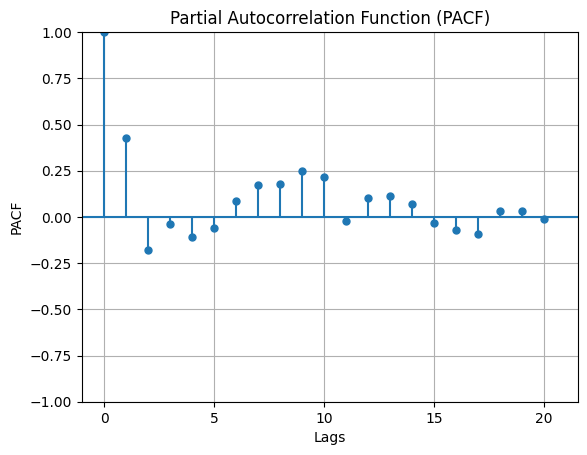

In [4]:
pacf_values = pacf(df_test['o2'], nlags=20)
 
# Print PACF values
print("Partial Autocorrelation Function (PACF) values:")
for lag, pacf_val in enumerate(pacf_values):
    print(f"Lag {lag}: {pacf_val}")
 
 
# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(df_test['o2'], lags=20)  # Change lags according to your data
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

NameError: name 'pyplot' is not defined

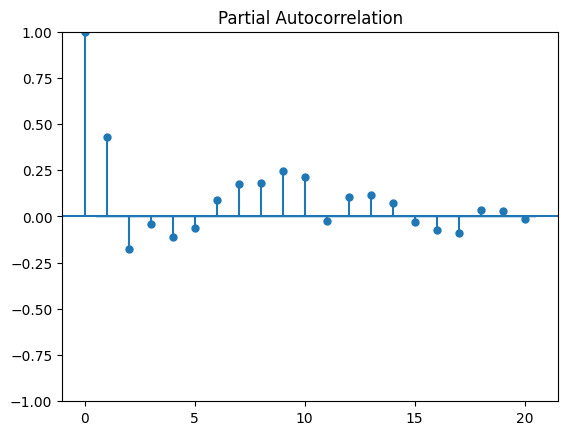

In [6]:
from pandas import read_csv
plot_pacf(df_test['o2'], lags=20)
pyplot.show()

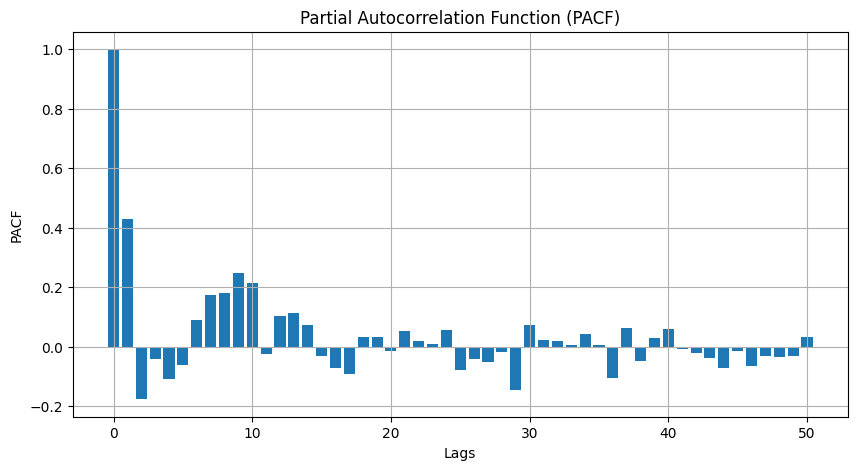

In [7]:
pacf_values = pacf(df_test['o2'], nlags=50)
 
# Plot PACF
plt.figure(figsize=(10, 5))
plt.bar(range(len(pacf_values)), pacf_values)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [2]:
pacf_values = pacf(df_test['o2'], nlags=100)
 
# Print PACF values
print("Partial Autocorrelation Function (PACF) values:")
for lag, pacf_val in enumerate(pacf_values):
    print(f"Lag {lag}: {pacf_val}")
 
 
# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(df_test['o2'], lags=30)  # Change lags according to your data
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

NameError: name 'pacf' is not defined

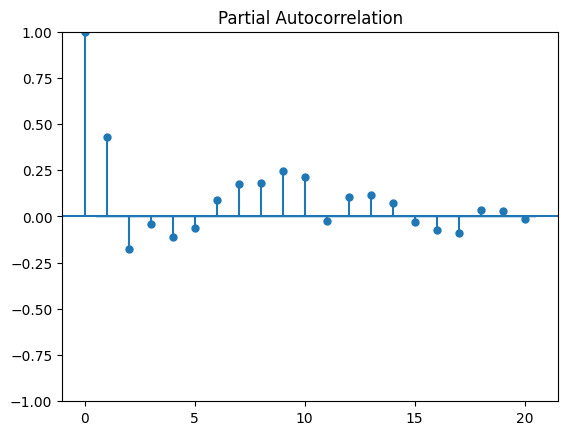

In [23]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_test['o2'], lags=20)
pyplot.show()

In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_test.columns

Index(['Unnamed: 0', 'date', 'lon_rounded_up', 'lat_rounded_up', 'o2', 'chl',
       'no3', 'po4', 'si', 'salinity',
       ...
       'salinity_lag_59', 'temp_lag_59', 'o2_lag_59', 'chl_lag_60',
       'no3_lag_60', 'po4_lag_60', 'si_lag_60', 'salinity_lag_60',
       'temp_lag_60', 'o2_lag_60'],
      dtype='object', length=432)

In [41]:
df_test.tail()

,date,lon_rounded_up,lat_rounded_up,o2,chl,no3,po4,si,salinity,temp,elevation,chl_lag_1,no3_lag_1,po4_lag_1,si_lag_1,salinity_lag_1,temp_lag_1,o2_lag_1,chl_lag_2,no3_lag_2,po4_lag_2,si_lag_2,salinity_lag_2,temp_lag_2,o2_lag_2,chl_lag_3,no3_lag_3,po4_lag_3,si_lag_3,salinity_lag_3,temp_lag_3,o2_lag_3,chl_lag_4,no3_lag_4,po4_lag_4,si_lag_4,salinity_lag_4,temp_lag_4,o2_lag_4,chl_lag_5,no3_lag_5,po4_lag_5,si_lag_5,salinity_lag_5,temp_lag_5,o2_lag_5,chl_lag_6,no3_lag_6,po4_lag_6,si_lag_6,salinity_lag_6,temp_lag_6,o2_lag_6,chl_lag_7,no3_lag_7,po4_lag_7,si_lag_7,salinity_lag_7,temp_lag_7,o2_lag_7,chl_lag_8,no3_lag_8,po4_lag_8,si_lag_8,salinity_lag_8,temp_lag_8,o2_lag_8,chl_lag_9,no3_lag_9,po4_lag_9,si_lag_9,salinity_lag_9,temp_lag_9,o2_lag_9,chl_lag_10,no3_lag_10,po4_lag_10,si_lag_10,salinity_lag_10,temp_lag_10,o2_lag_10,chl_lag_11,no3_lag_11,po4_lag_11,si_lag_11,salinity_lag_11,temp_lag_11,o2_lag_11,chl_lag_12,no3_lag_12,po4_lag_12,si_lag_12,salinity_lag_12,temp_lag_12,o2_lag_12,chl_lag_13,no3_lag_13,po4_lag_13,si_lag_13,salinity_lag_13,temp_lag_13,o2_lag_13,chl_lag_14,no3_lag_14,po4_lag_14,si_lag_14,salinity_lag_14,temp_lag_14,o2_lag_14,chl_lag_15,no3_lag_15,po4_lag_15,si_lag_15,salinity_lag_15,temp_lag_15,o2_lag_15,chl_lag_16,no3_lag_16,po4_lag_16,si_lag_16,salinity_lag_16,temp_lag_16,o2_lag_16,chl_lag_17,no3_lag_17,po4_lag_17,si_lag_17,salinity_lag_17,temp_lag_17,o2_lag_17,chl_lag_18,no3_lag_18,po4_lag_18,si_lag_18,salinity_lag_18,temp_lag_18,o2_lag_18,chl_lag_19,no3_lag_19,po4_lag_19,si_lag_19,salinity_lag_19,temp_lag_19,o2_lag_19,chl_lag_20,no3_lag_20,po4_lag_20,si_lag_20,salinity_lag_20,temp_lag_20,o2_lag_20,chl_lag_21,no3_lag_21,po4_lag_21,si_lag_21,salinity_lag_21,temp_lag_21,o2_lag_21,chl_lag_22,no3_lag_22,po4_lag_22,si_lag_22,salinity_lag_22,temp_lag_22,o2_lag_22,chl_lag_23,no3_lag_23,po4_lag_23,si_lag_23,salinity_lag_23,temp_lag_23,o2_lag_23,chl_lag_24,no3_lag_24,po4_lag_24,si_lag_24,salinity_lag_24,temp_lag_24,o2_lag_24,chl_lag_25,no3_lag_25,po4_lag_25,si_lag_25,salinity_lag_25,temp_lag_25,o2_lag_25,chl_lag_26,no3_lag_26,po4_lag_26,si_lag_26,salinity_lag_26,temp_lag_26,o2_lag_26,chl_lag_27,no3_lag_27,po4_lag_27,si_lag_27,salinity_lag_27,temp_lag_27,o2_lag_27,chl_lag_28,no3_lag_28,po4_lag_28,si_lag_28,salinity_lag_28,temp_lag_28,o2_lag_28,chl_lag_29,no3_lag_29,po4_lag_29,si_lag_29,salinity_lag_29,temp_lag_29,o2_lag_29,chl_lag_30,no3_lag_30,po4_lag_30,si_lag_30,salinity_lag_30,temp_lag_30,o2_lag_30,chl_lag_31,no3_lag_31,po4_lag_31,si_lag_31,salinity_lag_31,temp_lag_31,o2_lag_31,chl_lag_32,no3_lag_32,po4_lag_32,si_lag_32,salinity_lag_32,temp_lag_32,o2_lag_32,chl_lag_33,no3_lag_33,po4_lag_33,si_lag_33,salinity_lag_33,temp_lag_33,o2_lag_33,chl_lag_34,no3_lag_34,po4_lag_34,si_lag_34,salinity_lag_34,temp_lag_34,o2_lag_34,chl_lag_35,no3_lag_35,po4_lag_35,si_lag_35,salinity_lag_35,temp_lag_35,o2_lag_35,chl_lag_36,no3_lag_36,po4_lag_36,si_lag_36,salinity_lag_36,temp_lag_36,o2_lag_36,chl_lag_37,no3_lag_37,po4_lag_37,si_lag_37,salinity_lag_37,temp_lag_37,o2_lag_37,chl_lag_38,no3_lag_38,po4_lag_38,si_lag_38,salinity_lag_38,temp_lag_38,o2_lag_38,chl_lag_39,no3_lag_39,po4_lag_39,si_lag_39,salinity_lag_39,temp_lag_39,o2_lag_39,chl_lag_40,no3_lag_40,po4_lag_40,si_lag_40,salinity_lag_40,temp_lag_40,o2_lag_40,chl_lag_41,no3_lag_41,po4_lag_41,si_lag_41,salinity_lag_41,temp_lag_41,o2_lag_41,chl_lag_42,no3_lag_42,po4_lag_42,si_lag_42,salinity_lag_42,temp_lag_42,o2_lag_42,chl_lag_43,no3_lag_43,po4_lag_43,si_lag_43,salinity_lag_43,temp_lag_43,o2_lag_43,chl_lag_44,no3_lag_44,po4_lag_44,si_lag_44,salinity_lag_44,temp_lag_44,o2_lag_44,chl_lag_45,no3_lag_45,po4_lag_45,si_lag_45,salinity_lag_45,temp_lag_45,o2_lag_45,chl_lag_46,no3_lag_46,po4_lag_46,si_lag_46,salinity_lag_46,temp_lag_46,o2_lag_46,chl_lag_47,no3_lag_47,po4_lag_47,si_lag_47,salinity_lag_47,temp_lag_47,o2_lag_47,chl_lag_48,no3_lag_48,po4_lag_48,si_lag_48,salinity_lag_48,temp_lag_48,o2_lag_48,chl_lag_49,no3_lag_49,po4_lag_49,si_lag_49,salinity_lag_49,temp_lag_49,o2_lag_49,chl_lag_50,no3_l